In [ ]:
pip install tensorflow


In [ ]:
pip install matplotlib


In [ ]:
#IMPORTS

In [1]:

# Helper libraries
import numpy as np
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


In [12]:
print(tf.__version__)


2.16.1


In [2]:
# Base directory containing the dataset with subfolders for each emotion
dataset_dir = 'dataset/'

# Dictionary to hold the image file paths, categorized by emotion
image_paths = {emotion: [] for emotion in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, emotion))}
print(image_paths)

{'amusement': [], 'anger': [], 'awe': [], 'contentment': [], 'disgust': [], 'excitement': [], 'fear': [], 'sadness': []}


In [3]:

# Walk through the directory structure
for emotion, paths in image_paths.items():
    emotion_folder = os.path.join(dataset_dir, emotion)
    for dirname, _, filenames in os.walk(emotion_folder):
        for filename in filenames:
            # Check if the file is an image based on its extension
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                # Add the absolute image file path to the list corresponding to the emotion
                paths.append(os.path.join(dirname, filename))

# Display the number of images in each category
for emotion, paths in image_paths.items():
    print(f"{emotion}: {len(paths)} images")


amusement: 4923 images
anger: 1255 images
awe: 3133 images
contentment: 5356 images
disgust: 1657 images
excitement: 2914 images
fear: 1046 images
sadness: 2901 images


Found 23185 images belonging to 8 classes.


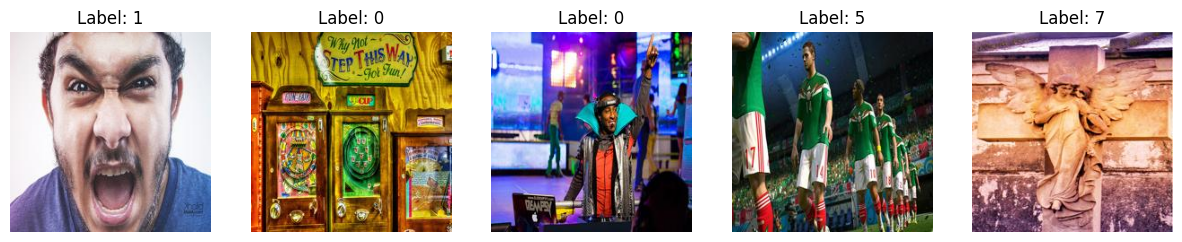

In [4]:

# Define label map
label_map = {'amusement': 0, 'anger': 1, 'awe': 2, 'contentment': 3, 'disgust': 4, 'excitement': 5, 'fear': 6, 'sadness': 7}

# Load image paths and labels
image_paths = []
labels = []

for label in label_map:
    emotion_folder = os.path.join(dataset_dir, label)
    for filename in os.listdir(emotion_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            image_paths.append(os.path.join(emotion_folder, filename))
            labels.append(label_map[label])  # Corrected to append the numeric label

            
# Convert labels to categorical format
labels = to_categorical(labels, num_classes=len(label_map))

# Define ImageDataGenerator for resizing and normalizing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    preprocessing_function=lambda x: tf.image.resize(x, (224, 224))  # Resize images to 224x224
)

# Flow from directory (without augmentation)
data_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,  # Define batch size
    class_mode='categorical',  # Use categorical labels
    shuffle=True  # Shuffle the data
)
# Get a batch of images and labels from the generator
images, labels = next(data_generator)

# Print some images and their labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Display 5 images
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.title.set_text(f"Label: {np.argmax(labels[i])}")
    ax.axis('off')
plt.show()


In [ ]:
# Number of images to display per category
num_images_to_display = 5

# Get the list of categories
categories = [category for category in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, category))]

# Iterate over categories
for category in categories:
    category_path = Path(dataset_dir) / category
    image_paths = list(category_path.glob('*.*'))  # Get all image paths
    random_image_paths = random.sample(image_paths, min(len(image_paths), num_images_to_display))  # Randomly select images

    # Display the images
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 10))  # Adjust the figure size as needed
    fig.suptitle(category, fontsize=20)
    
    for ax, image_path in zip(axes, random_image_paths):
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


In [ ]:

# Dictionary to hold the category, number of images, and sizes of first few images
category_info = {}

# Iterate over categories
for category in categories:
    category_path = Path(dataset_dir) / category
    image_paths = list(category_path.glob('*.*'))  # Get all image paths
    category_info[category] = {
        'count': len(image_paths),
        'image_sizes': [Image.open(image_path).size for image_path in image_paths[:5]]  # Sizes of the first 5 images
    }

# Print out the category information
for category, info in category_info.items():
    print(f"Category: {category}")
    print(f"Number of images: {info['count']}")
    print("Sizes of the first 5 images:")
    for size in info['image_sizes']:
        print(size)
    print()


In [ ]:
#RESNET

In [6]:
# Define label map
label_map = {'amusement': 0, 'anger': 1, 'awe': 2, 'contentment': 3, 'disgust': 4, 'excitement': 5, 'fear': 6, 'sadness': 7}

# Load and prepare image paths and labels
image_paths = []
labels = []

for label, idx in label_map.items():
    emotion_folder = os.path.join(dataset_dir, label)
    for filename in os.listdir(emotion_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            image_paths.append(os.path.join(emotion_folder, filename))
            labels.append(idx)

# Split the data
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_labels = to_categorical(train_labels, num_classes=len(label_map))
test_labels = to_categorical(test_labels, num_classes=len(label_map))

# Define ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Function to load images (since we're using paths and labels)
def generate_data_from_paths(paths, labels, datagen, batch_size=32):
    while True:
        for start in range(0, len(paths), batch_size):
            end = min(start + batch_size, len(paths))
            batch_paths = paths[start:end]
            batch_labels = labels[start:end]
            batch_images = [tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224)) for img_path in batch_paths]
            batch_images = np.array([tf.keras.preprocessing.image.img_to_array(img) for img in batch_images])
            batch_images = datagen.standardize(batch_images)
            yield batch_images, np.array(batch_labels)

# Prepare data generators
train_generator = generate_data_from_paths(train_paths, train_labels, train_datagen)
test_generator = generate_data_from_paths(test_paths, test_labels, test_datagen)


In [ ]:
# Load ResNet50 model, pretrained on ImageNet, without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_map), activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=len(train_paths) // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_paths) // 32
)

Epoch 1/10
153/579 ━━━━━━━━━━━━━━━━━━━━ 51:38 7s/step - accuracy: 0.1984 - loss: 2.0862

In [ ]:
# BASE MODEL

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

